In [ ]:
#Importing Necessary Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import math
import seaborn as sns
!pip install shap
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap
from sklearn.ensemble import RandomForestRegressor


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 20.4 MB/s 


In [ ]:
# Connecting to Google drive for importing datasets.
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Importing the data
store_1 = pd.read_csv("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_01.csv")
store_2 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_02.csv") #The data is formated as excel sheet but stored as csv extension.
store_3 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_03.xlsx")
store_4 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_04.xlsx")
store_5 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_05.xlsx")
store_6 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_06.xlsx")
store_7 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_07.xlsx")
store_8 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_08.xlsx")
store_9 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_09.xlsx")
store_10 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_10.xlsx")
store_11 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_11_35.xlsx")


In [ ]:
#changing Store 1 date format to make it consistent with the data
store_1['Date'] = pd.to_datetime(store_1['Date'], format='%m/%d/%Y').dt.strftime('%Y/%m/%d')

#concatinating all the stores together
features = pd.concat([store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,store_11])
features

,Store,Date,IsHoliday,Temperature,gas_price,discount_promotional,discount_clearance,discount_damaged_good,discount_competitive,CPI,Unemployment
0,1,2010/02/05,False,59.33,3.360,9667.50,268.29,0.60,8368.15,223.659114,6.833
1,1,2010/02/12,True,51.65,3.409,8687.47,1594.87,2.20,2144.87,223.753643,6.833
2,1,2010/02/19,False,52.39,3.510,2706.87,3128.74,1.88,2396.68,223.917015,6.833
3,1,2010/02/26,False,60.12,3.555,6129.28,1802.84,NaN,301.48,224.132020,6.833
4,1,2010/03/05,False,61.65,3.630,3552.58,601.32,NaN,2666.22,224.347025,6.833
...,...,...,...,...,...,...,...,...,...,...,...
4545,35,2013-06-28 00:00:00,False,77.34,3.639,4764.55,85.65,NaN,4660.01,NaN,NaN
4546,35,2013-07-05 00:00:00,False,77.41,3.614,6333.87,138.09,610.35,7224.45,NaN,NaN
4547,35,2013-07-12 00:00:00,False,80.74,3.614,4798.18,130.88,22.05,2351.60,NaN,NaN
4548,35,2013-07-19 00:00:00,False,83.36,3.737,2318.53,122.30,23.45,771.35,NaN,NaN


In [ ]:
#Importing rest of the data
stores = pd.read_csv("/content/drive/MyDrive/CECS551_dataset_01/stores.csv")
sales = pd.read_csv("/content/drive/MyDrive/CECS551_dataset_01/train.csv")

In [ ]:
#Creating columns: Year, no of week.
sales.Date = pd.to_datetime(sales['Date'], format='%Y-%m-%d')

sales['Year'] = pd.to_datetime(sales['Date'], format='%Y-%m-%d').dt.year

sales['n_of_Week'] = pd.to_datetime(sales['Date'], format='%Y-%m-%d').dt.isocalendar().week

sales['IsHoliday'] = sales['IsHoliday'].astype('int64')# Transform IsHoliday from True & False to 1 & 0
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,n_of_Week
0,1,1,2010-02-05,24924.50,0,2010,5
1,1,1,2010-02-12,46039.49,1,2010,6
2,1,1,2010-02-19,41595.55,0,2010,7
3,1,1,2010-02-26,19403.54,0,2010,8
4,1,1,2010-03-05,21827.90,0,2010,9


In [ ]:
#Merging sales and store data
sales = pd.merge(sales,stores[['Store','Type','Size']])

In [ ]:
# Since the date was stored as object in the dataset, converting it to datetime format.
features['Date'] = pd.to_datetime(features['Date'], format='%Y/%m/%d')
features.head()

,Store,Date,IsHoliday,Temperature,gas_price,discount_promotional,discount_clearance,discount_damaged_good,discount_competitive,CPI,Unemployment
0,1,2010-02-05,False,59.33,3.360,9667.50,268.29,0.60,8368.15,223.659114,6.833
1,1,2010-02-12,True,51.65,3.409,8687.47,1594.87,2.20,2144.87,223.753643,6.833
2,1,2010-02-19,False,52.39,3.510,2706.87,3128.74,1.88,2396.68,223.917015,6.833
3,1,2010-02-26,False,60.12,3.555,6129.28,1802.84,NaN,301.48,224.132020,6.833
4,1,2010-03-05,False,61.65,3.630,3552.58,601.32,NaN,2666.22,224.347025,6.833


In [ ]:
#Merging all the data to complete the whole dataset
sales = pd.merge(sales, features[['Store','Date','Unemployment','gas_price','Temperature','CPI','discount_promotional','discount_clearance','discount_damaged_good','discount_competitive']])
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,n_of_Week,Type,Size,Unemployment,gas_price,Temperature,CPI,discount_promotional,discount_clearance,discount_damaged_good,discount_competitive
0,1,1,2010-02-05,24924.50,0,2010,5,A,151315,6.833,3.36,59.33,223.659114,9667.5,268.29,0.6,8368.15
1,1,2,2010-02-05,50605.27,0,2010,5,A,151315,6.833,3.36,59.33,223.659114,9667.5,268.29,0.6,8368.15
2,1,3,2010-02-05,13740.12,0,2010,5,A,151315,6.833,3.36,59.33,223.659114,9667.5,268.29,0.6,8368.15
3,1,4,2010-02-05,39954.04,0,2010,5,A,151315,6.833,3.36,59.33,223.659114,9667.5,268.29,0.6,8368.15
4,1,5,2010-02-05,32229.38,0,2010,5,A,151315,6.833,3.36,59.33,223.659114,9667.5,268.29,0.6,8368.15


In [ ]:
#Finding NaN values in Discount columns.
markdowns = ['discount_clearance','discount_promotional','discount_damaged_good', 'discount_competitive']
for column_name in markdowns:
    markdown_frac = features[column_name].isnull().sum() / features[column_name].shape[0]
    print(f"{int(100 * round(markdown_frac, 2))}% of {column_name} values are NaN.")

61% of discount_clearance values are NaN.
49% of discount_promotional values are NaN.
53% of discount_damaged_good values are NaN.
52% of discount_competitive values are NaN.


In [ ]:
#Handling missing values of the discount columns
sales[markdowns] = sales[markdowns].fillna(0)
sales.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Year,n_of_Week,Size,Unemployment,gas_price,Temperature,CPI,discount_promotional,discount_clearance,discount_damaged_good,discount_competitive
count,340287.000000,340287.000000,340287.000000,340287.000000,340287.000000,340287.000000,340287.000000,339369.000000,340287.000000,340287.000000,339369.000000,340287.000000,340287.000000,340287.00000,340287.000000
mean,17.801926,43.923047,16756.346852,0.070411,2010.966951,25.820651,145409.939604,7.911781,3.371271,59.624196,170.141328,2916.332024,984.482940,539.21251,1214.278023
std,10.015969,30.023826,23494.800295,0.255839,0.796800,14.157161,56536.506905,1.794918,0.454536,18.456037,39.795059,6383.728593,5420.596925,5949.48593,4112.284853
min,1.000000,1.000000,-4988.940000,0.000000,2010.000000,1.000000,34875.000000,3.879000,2.514000,-2.060000,126.064000,0.000000,-265.760000,-29.10000,0.000000
25%,9.000000,19.000000,2540.495000,0.000000,2010.000000,14.000000,112238.000000,6.842000,2.942000,46.280000,132.152129,0.000000,0.000000,0.00000,0.000000
50%,18.000000,37.000000,8141.060000,0.000000,2011.000000,26.000000,151315.000000,7.852000,3.467000,61.440000,141.474286,0.000000,0.000000,0.00000,0.000000
75%,26.000000,72.000000,21156.565000,0.000000,2012.000000,38.000000,203742.000000,8.549000,3.742000,73.670000,213.818636,3668.400000,15.000000,6.06000,671.430000
max,35.000000,99.000000,693099.360000,1.000000,2012.000000,52.000000,219622.000000,14.313000,4.468000,100.140000,228.729864,88646.760000,104519.540000,141630.61000,67474.850000


In [ ]:
#Droping all the missing values.
sales.dropna(subset=['Unemployment'], how='all', inplace=True)
sales.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Year,n_of_Week,Size,Unemployment,gas_price,Temperature,CPI,discount_promotional,discount_clearance,discount_damaged_good,discount_competitive
count,339369.000000,339369.000000,339369.00000,339369.000000,339369.000000,339369.000000,339369.000000,339369.000000,339369.000000,339369.000000,339369.000000,339369.000000,339369.000000,339369.000000,339369.000000
mean,17.847376,43.921590,16744.06308,0.070602,2010.966862,25.825709,145393.966296,7.911781,3.371021,59.570501,170.141328,2918.294180,986.507690,540.407551,1216.274913
std,9.991261,30.023589,23483.06965,0.256159,0.797875,14.174629,56612.086368,1.794918,0.455112,18.450090,39.795059,6391.971584,5427.765615,5957.480653,4117.595494
min,1.000000,1.000000,-4988.94000,0.000000,2010.000000,1.000000,34875.000000,3.879000,2.514000,-2.060000,126.064000,0.000000,-265.760000,-29.100000,0.000000
25%,9.000000,19.000000,2538.00000,0.000000,2010.000000,14.000000,112238.000000,6.842000,2.942000,46.250000,132.152129,0.000000,0.000000,0.000000,0.000000
50%,18.000000,37.000000,8136.67000,0.000000,2011.000000,26.000000,151315.000000,7.852000,3.467000,61.360000,141.474286,0.000000,0.000000,0.000000,0.000000
75%,26.000000,72.000000,21140.40000,0.000000,2012.000000,38.000000,203742.000000,8.549000,3.742000,73.620000,213.818636,3690.950000,12.790000,6.010000,677.290000
max,35.000000,99.000000,693099.36000,1.000000,2012.000000,52.000000,219622.000000,14.313000,4.468000,100.140000,228.729864,88646.760000,104519.540000,141630.610000,67474.850000


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


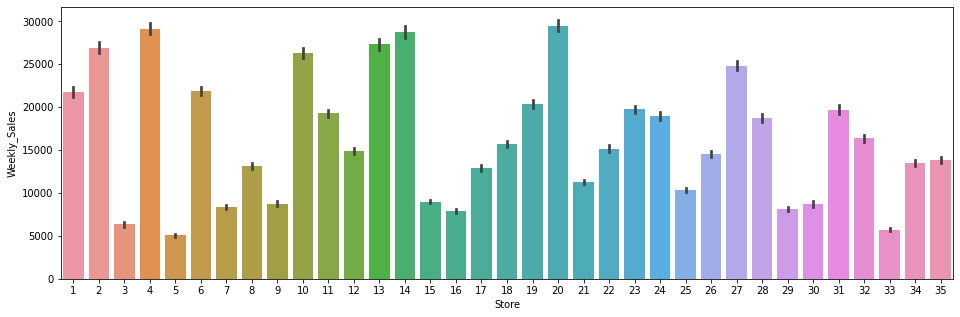

In [ ]:
fig = plt.figure(figsize=(16,5))
sns.barplot(sales['Store'],sales['Weekly_Sales'])

Analyzing weekly sales for each store. Store number 20 is best performing in comparision to others in terms of weekly sales.

#A. Identifying the key variables for the model using correlation plots,heatmaps, histograms, feature importance.

In [ ]:
#Generating Correlation values w.r.t. Weekly_Sales
corr_matrix = sales.corr()
corr_matrix['Weekly_Sales'].sort_values(ascending=False)

Weekly_Sales             1.000000
Size                     0.243874
Dept                     0.122189
discount_promotional     0.039635
discount_damaged_good    0.037546
discount_competitive     0.032482
n_of_Week                0.029229
discount_clearance       0.017863
IsHoliday                0.014325
gas_price                0.006333
Temperature              0.004622
Year                    -0.012024
Unemployment            -0.018903
CPI                     -0.040949
Store                   -0.053978
Name: Weekly_Sales, dtype: float64

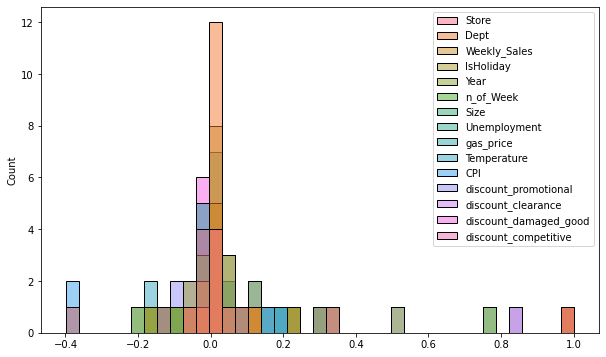

In [ ]:
#plotting Correlation Histogram
ax = plt.subplots(figsize=(10, 6))
sns.histplot(sales.corr())

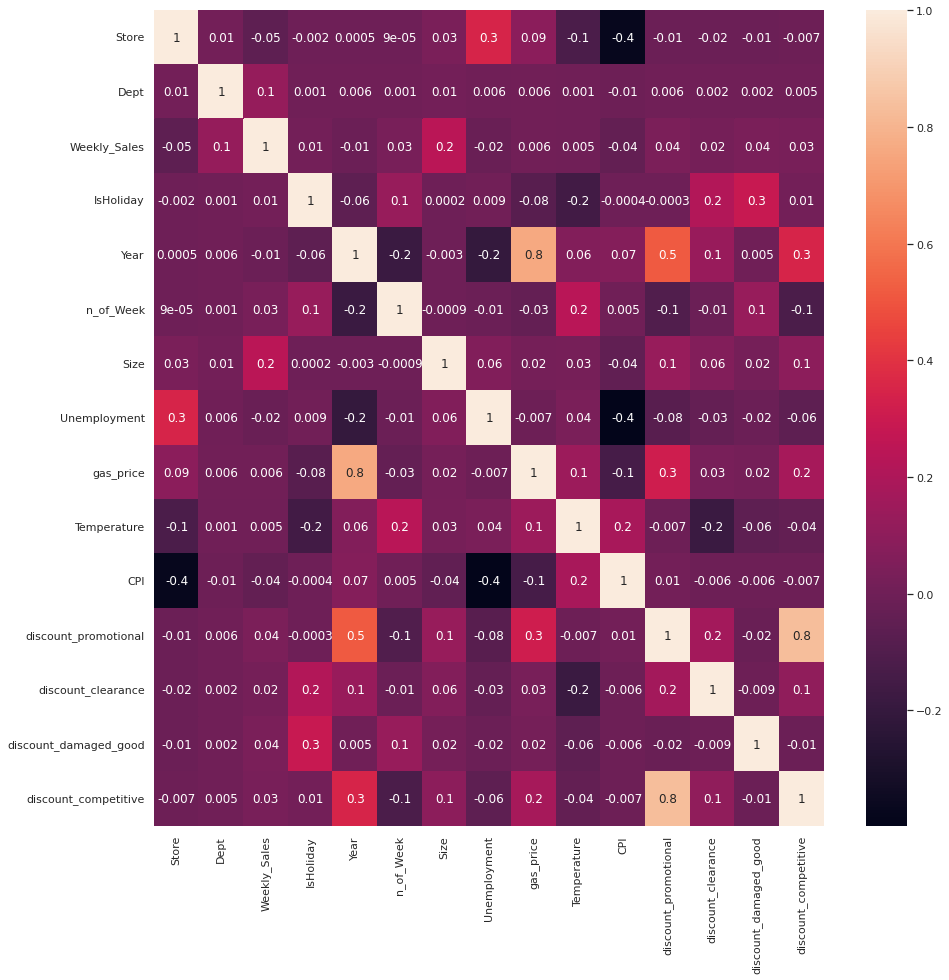

In [ ]:
#Generaing Correlation Matrix Heatmap
sns.set(style="white")
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(sales.corr(),annot=True, fmt='.1g',xticklabels=1, yticklabels=1)

In [ ]:
#Selecting target variable and train test splitting[80/20]
target = 'Weekly_Sales'
y = sales[target]
X = sales.drop(columns=[target, "Date","Type"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1066)

In [ ]:
#Fitting the random forest regressor and calculating rmse
model = RandomForestRegressor(n_estimators=150)
model.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
rmse

3934.7830542125507

Text(0.5, 1.0, 'Feature Importance')

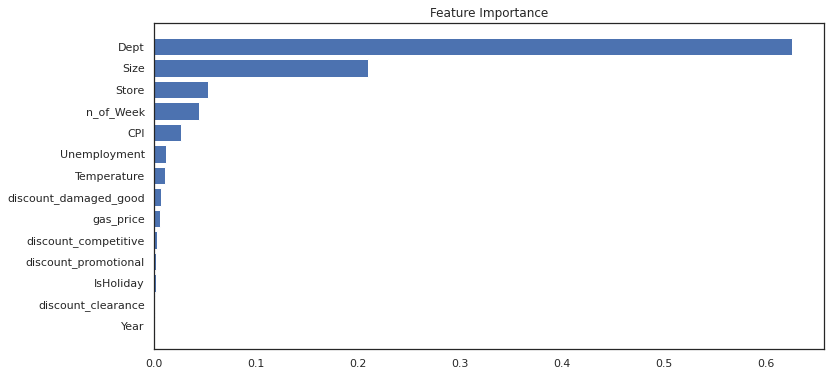

In [ ]:
#Vizualizing the important features using horizontal barplot.
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
# explainer = shap.Explainer(model)
# shap_values = explainer(X_test)
# shap_importance = shap_values.abs.mean(0).values
# sorted_idx = shap_importance.argsort()
# fig = plt.figure(figsize=(12, 6))
# plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
# plt.title('SHAP Importance')

#B. Visualizing Weekly and Monthly sales patterns for the top 35% of the department sales

In [ ]:
#Selecting the first 10 stores
temp = sales.loc[sales['Store'] <11]
temp['Month'] = temp['Date'].dt.month
temp['Year'] = temp['Date'].dt.year


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
temp.sort_values(by=['Weekly_Sales'], inplace=True, ascending=False)#sorting weekly sales in descending order(Highest to lowest)
top_35  = temp.apply(lambda x: x.head(int(len(x)*0.35))).reset_index(drop=True)#Generating the top 35% weekly sales


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


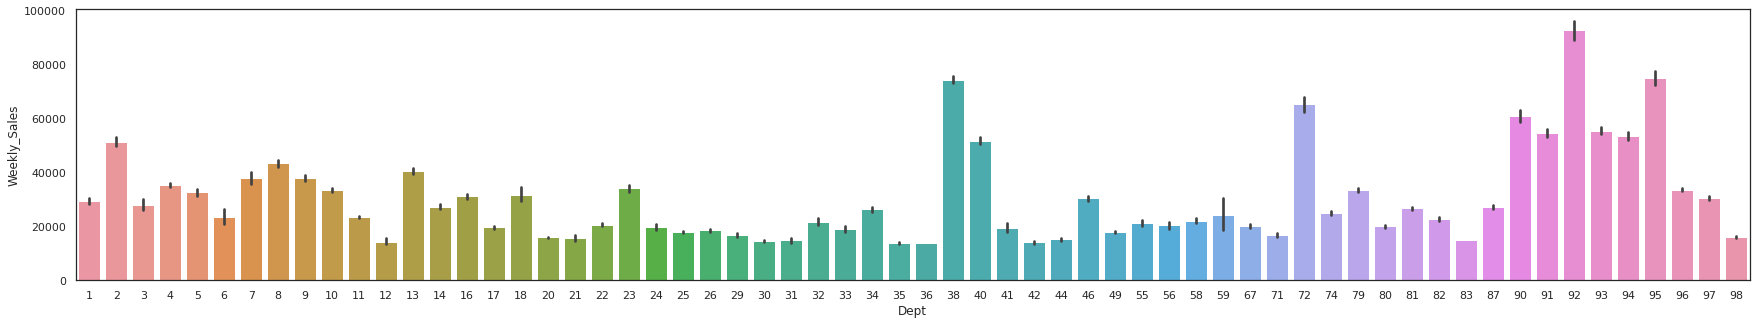

In [ ]:
#Plotting Weekly sales for all departments
fig = plt.figure(figsize=(30,5))
sns.barplot(top_35['Dept'],top_35['Weekly_Sales'])

In [ ]:
# fig = plt.figure(figsize=(30,5))
# top = top_35.groupby("Month").agg({"Weekly_Sales":"mean"})
# # top = top_35.groupby(top_35.Month)['Weekly_Sales'].sum()
# top
# top_30 = sales.loc[sales["Store"].isin(top.)]
# # sns.barplot(top['Dept'],top['Weekly_Sales'])

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


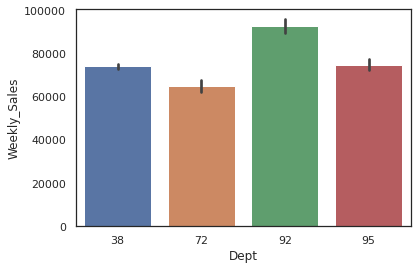

In [ ]:
#Top 4 departments with higest weekly sales
top_dept = [38,72,92,95]
top_dept1 = top_35[top_35['Dept'].isin(top_dept)]
top_dept1
sns.barplot(top_dept1['Dept'],top_dept1['Weekly_Sales'])


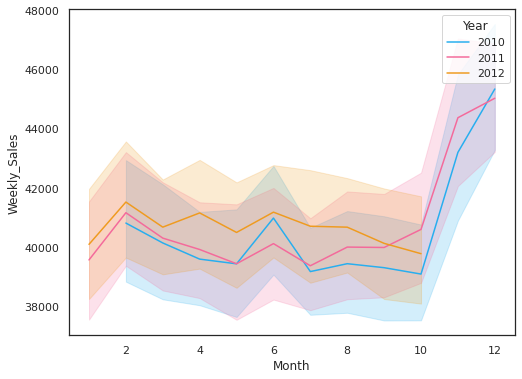

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x = "Month", y = "Weekly_Sales", data=top_35, hue ="Year",palette=["#27aeef", "#f46a9b", "#ef9b20"])

###The best department is Dept 92 across 10 stores from the top 35% Weekly sales


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


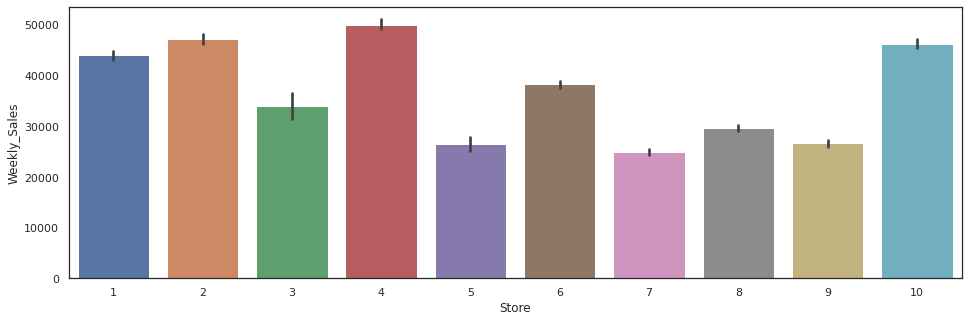

In [ ]:
#Plotting weekly sales by store
fig = plt.figure(figsize=(16,5))
sns.barplot(top_35['Store'],top_35['Weekly_Sales'])

Best store is Store 4 within top 35% of weekly sales

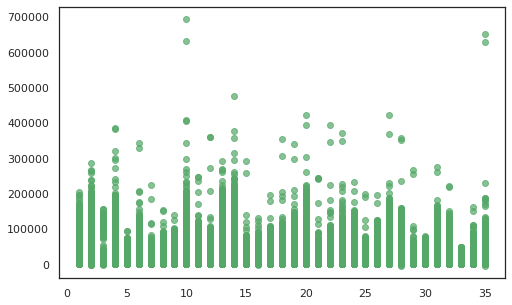

In [ ]:
fig = plt.figure(figsize=(8,5))

plt.scatter(sales['Store'],sales['Weekly_Sales'], alpha=0.7, color='g')

#C.	Investigate the relationship between weekly sales over CPI and unemployment for the first 10 stores.

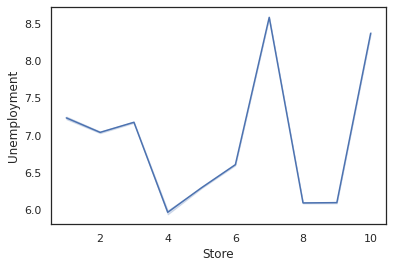

In [ ]:
sns.lineplot(data=temp, y="Unemployment", x="Store")

Vizualing Unemployment Storewise

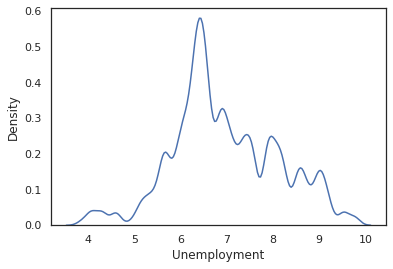

In [ ]:
sns.kdeplot(data=temp, x="Unemployment")

Density of unemployment rate

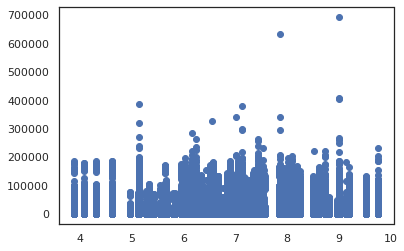

In [ ]:
plt.scatter(temp['Unemployment'], temp['Weekly_Sales'])
plt.show()

The above plot suggests the absence of a linear relationship between the two variables. We can quantify this inference by calculating the correlation coefficient using the line of code below.

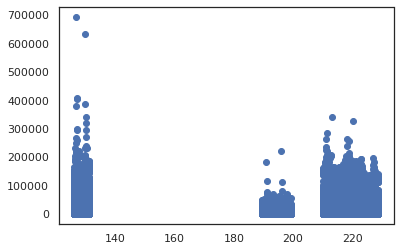

In [ ]:
plt.scatter(temp['CPI'], temp['Weekly_Sales'])
plt.show()

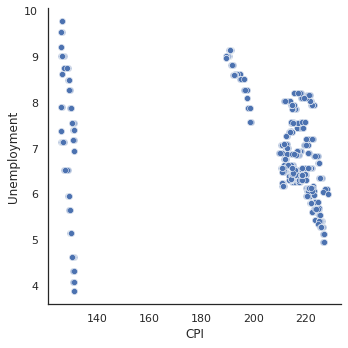

In [ ]:
sns.relplot(y='Unemployment', x='CPI', data=temp)

Vizualizing the relation between unemployment and CPI

[Text(0.5, 1.0, 'Stores by Type')]

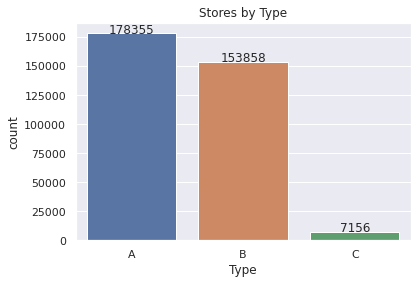

In [ ]:
sns.set(style='darkgrid')
ax = sns.countplot(x='Type', data=sales)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
ax.set(title='Stores by Type')

Number of Stores per each type

#D.	Investigate the impact of various types of discounts, for example, discount promotional, discount clearance, discount damaged good and discount competitive on the overall sales

Understanding the data distribution for all the given discounts by plotting their density.

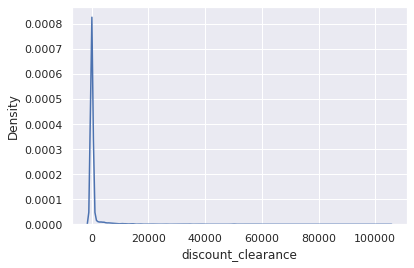

In [ ]:
sns.kdeplot(data=sales, x="discount_clearance")

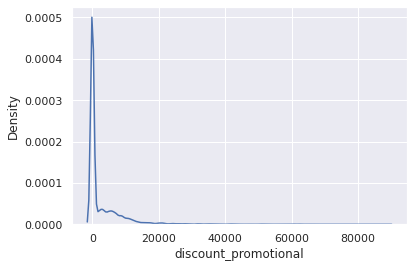

In [ ]:
sns.kdeplot(data=sales, x="discount_promotional")

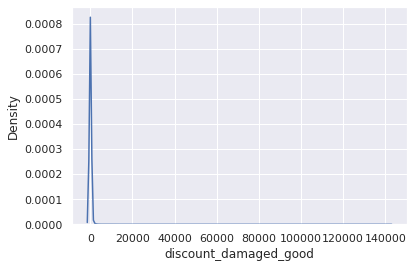

In [ ]:
sns.kdeplot(data=sales, x="discount_damaged_good")

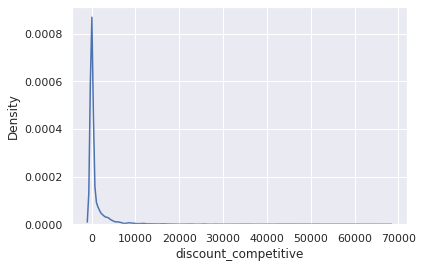

In [ ]:
sns.kdeplot(data=sales, x="discount_competitive")

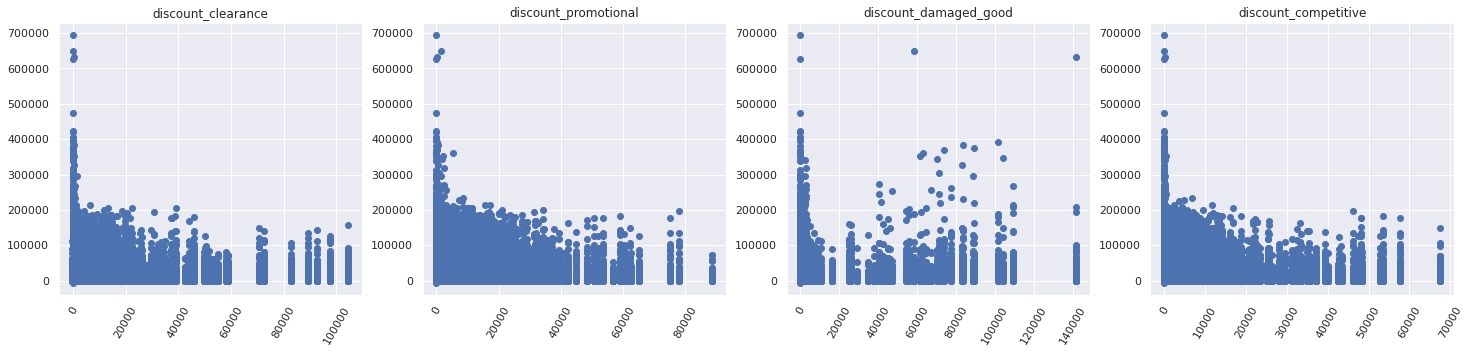

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(25, 5))
titles = ['discount_clearance','discount_promotional','discount_damaged_good', 'discount_competitive']
for i in range(4):
    ax[i].scatter(sales[f'{titles[i]}'], sales['Weekly_Sales'])
    ax[i].tick_params(axis='x', labelrotation=60)
    ax[i].set_title(f'{titles[i]}')

plt.show()

Analyzing the impact of various discounts on the overall sales.

In [ ]:
df_top_stores = sales.groupby(by=['Store'], as_index=False).sum()
df_top_stores = df_top_stores.sort_values('Weekly_Sales', ascending=False)[:10]

lst_top_30 = df_top_stores['Store']
lst_top_30.to_list()

[20, 4, 14, 13, 2, 10, 27, 6, 19, 1]

In [ ]:
top_30 = sales.loc[sales["Store"].isin(lst_top_30)]

Fetching the dataset for the top 30% of the best performing.

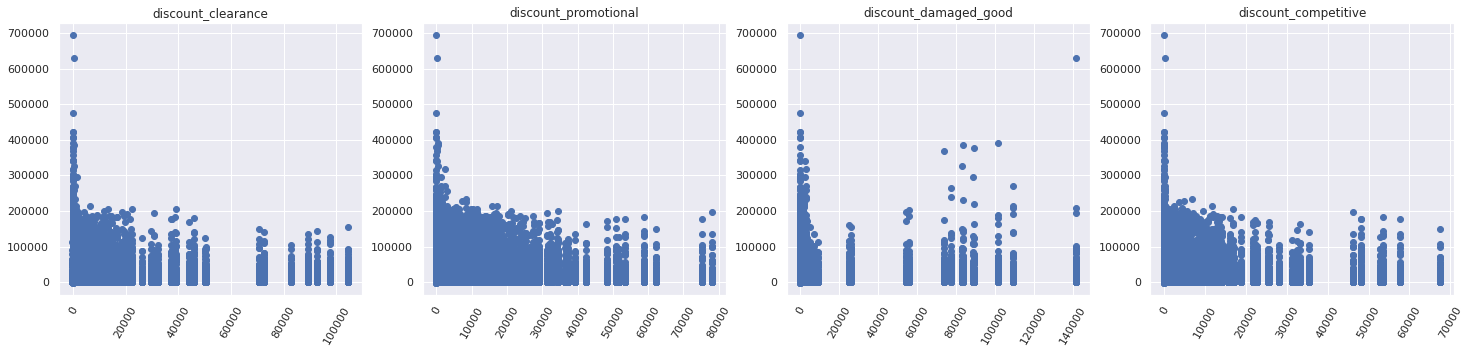

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(25, 5))
titles = ['discount_clearance','discount_promotional','discount_damaged_good', 'discount_competitive']
for i in range(4):
    ax[i].scatter(top_30[f'{titles[i]}'], top_30['Weekly_Sales'])
    ax[i].tick_params(axis='x', labelrotation=60)
    ax[i].set_title(f'{titles[i]}')

plt.show()

Impact of various discount on top 30% of the best performing stores.

In [ ]:
df_bottom_stores = sales.groupby(by=['Store'], as_index=False).sum()
df_bottom_stores = df_bottom_stores.sort_values('Weekly_Sales', ascending=True)[:10]
lst_bottom_30 = df_bottom_stores['Store']
lst_bottom_30.to_list()


[33, 5, 3, 30, 16, 29, 9, 7, 15, 25]

In [ ]:
bottom_30 = sales.loc[sales["Store"].isin(lst_bottom_30)]

Fetching the dataset for the bottom 30% of the best performing.

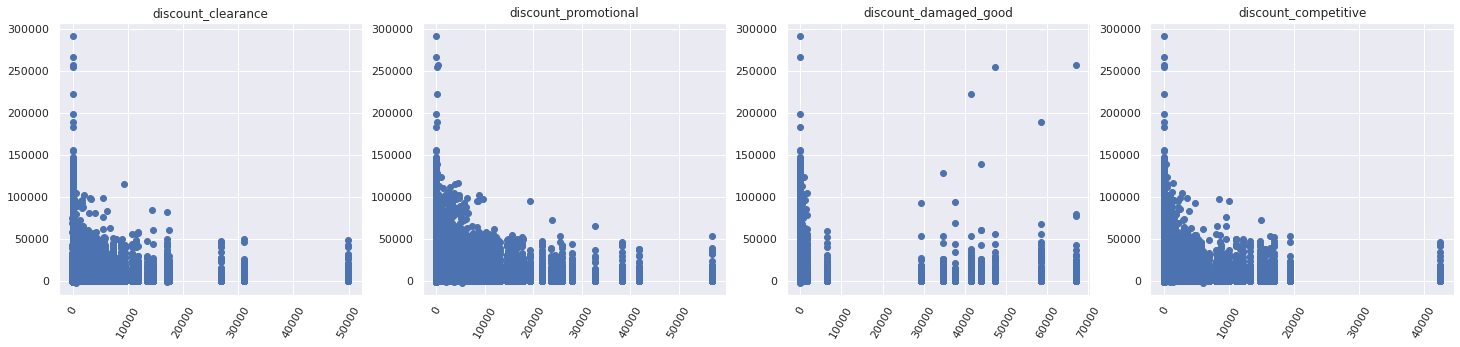

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(25, 5))
titles = ['discount_clearance','discount_promotional','discount_damaged_good', 'discount_competitive']
for i in range(4):
    ax[i].scatter(bottom_30[f'{titles[i]}'], bottom_30['Weekly_Sales'])
    ax[i].tick_params(axis='x', labelrotation=60)
    ax[i].set_title(f'{titles[i]}')

plt.show()

Impact of various discount on bottom 30% of the best performing stores.

#E. Identify the products which are highly impacted by external factors: “temperature”, “gas price”, and “holiday”.

Since, the dataset does not contain any products, we analyze the impact of external factors like temperature, gas price, and holiday on overall weekly_sales.

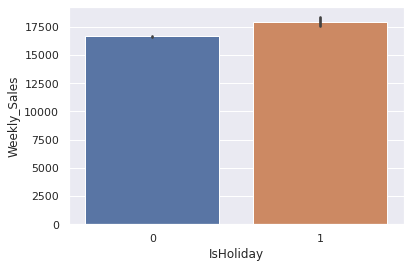

In [ ]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=sales)

We observed an increase in sales for weeks with holidays.

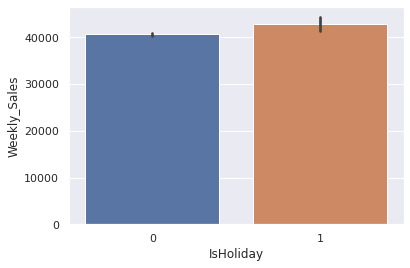

In [ ]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=top_35)

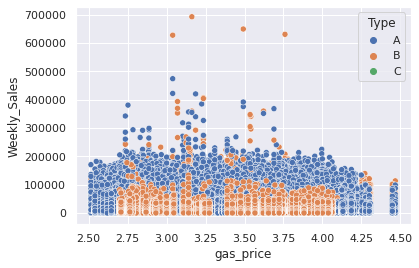

In [ ]:
sns.scatterplot(x='gas_price', y='Weekly_Sales', hue="Type", data=sales)

We saw plumetion in sales after price of gas exceeded by $4.25. Also Type A had higher sales as compared to other types.

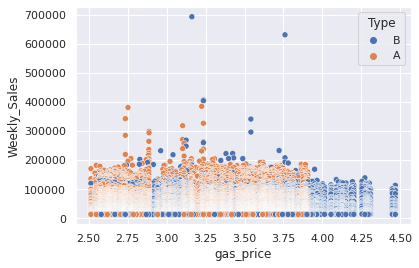

In [ ]:
sns.scatterplot(x='gas_price', y='Weekly_Sales', hue="Type", data=top_35)

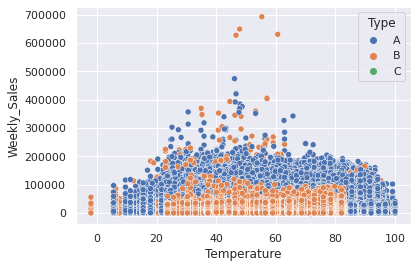

In [ ]:
sns.scatterplot(x='Temperature', y='Weekly_Sales', hue="Type", data=sales)

At extreme temperatures, i.e, under 20 and over 80, we saw decrease in sales especially for type B stores. The highest sales can be seen between temperature range of 35 to 60.

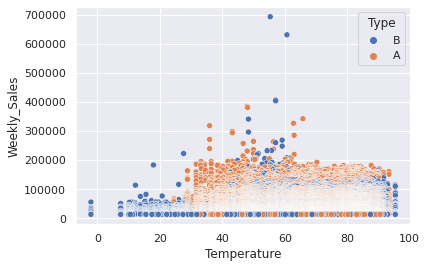

In [ ]:
sns.scatterplot(x='Temperature', y='Weekly_Sales', hue="Type", data=top_35)